In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import copy, torch, os
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
data_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)
print(train_df.columns.values)
data_NN = copy.copy(train_df)

# Data Analysis

The test set contains 891 train data and 418 test data with total of 1309 data
- 843 is male and 466 is female
- 56 person is infant (<=5 yr old) while 22 person is under 20
- The oldest person on the ship is 80 yr old, survived 
- Has 1 sibling/Spouse

(array([13.,  5., 11.,  5., 51., 48., 56., 54., 30., 34., 28., 17., 23.,
        15.,  7.,  8.,  7.,  6.,  2.,  4.]),
 array([ 1.  ,  4.65,  8.3 , 11.95, 15.6 , 19.25, 22.9 , 26.55, 30.2 ,
        33.85, 37.5 , 41.15, 44.8 , 48.45, 52.1 , 55.75, 59.4 , 63.05,
        66.7 , 70.35, 74.  ]),
 <BarContainer object of 20 artists>)

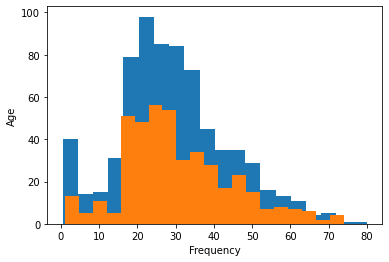

In [45]:
plt.hist(data_df['Age'][data_df['Survived']>-1],bins=20)
plt.xlabel('Frequency')
plt.ylabel('Age')
plt.hist(data_df['Age'][data_df['Survived']==0],bins=20)


# Correlation check
The result show, you will likely to survive if
- You are Female (74% survival rate)
- You are from upper class (63% survival rate)
- Embarked From Cherbourg (56% survival rate)
- Ship with 1 sibling/spouse (53% survival rate)
- Ship with 3 child/parents (60% survival rate)

In [214]:
print(train_df[['Sex','Survived']].groupby('Sex',as_index=False).mean())
print(train_df[['Pclass','Survived']].groupby('Pclass',as_index=False).mean())
print(train_df[['Pclass','Survived']].groupby('Pclass',as_index=False).mean())
print(train_df[['Embarked','Survived']].groupby('Embarked',as_index=False).mean())
print(train_df[['SibSp','Survived']].groupby('SibSp',as_index=False).mean())
print(train_df[['Parch','Survived']].groupby('Parch',as_index=False).mean())
print(train_df[['Age','Survived']].groupby([pd.cut(train_df['Age'],list(range(0,80,10)))]).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
                Age  Survived
Age                          
(0, 10]    4.268281  0.593750
(10, 20]  17.317391  0.382609
(20, 30]  25.423913  0.365217
(30, 40]  35.051613  0.445161
(40, 50]  45.372093  0.383721
(50, 60]  54.892857  0.404762
(60, 70]  63.882353  0.235294


# Processing

In [47]:
data_df['Title'] = data_df['Name'].str.extract(r'\,.([A-Z].*\.)')
data_df = data_df.drop(columns=['Name','Ticket','Cabin','PassengerId'])
data_df['Age']  = data_df['Age'].fillna(0)
title_list_count = (data_df.groupby(['Title'],as_index=False)).count().values[:,:2]
title_list_count[:,1] = title_list_count[:,1]<5
title_list_rare = title_list_count[:,0][title_list_count[:,1]==True].astype(str)
for x in range(data_df.shape[0]):
    if data_df['Title'].loc[x] in title_list_rare:
        data_df['Title'].loc[x] = 'etc'

In [54]:
from sklearn import preprocessing
label_list = ['Sex','Title','Embarked']
for i in label_list:
    le = preprocessing.LabelEncoder()
    le.fit(data_df[i])
    data_df[i] = le.transform(data_df[i])
train_data = data_df[data_df['Survived']>=0]
test_data = data_df[data_df['Survived'].isnull()]
X_train = train_data.drop(columns=['Survived'])
y_train = train_data['Survived']

X_test = test_data.drop(columns=['Survived'])
X_test['Fare'] = X_test['Fare'].fillna(0)

# Simple Model


In [194]:
from sklearn.model_selection import train_test_split
X_train0, X_train1, y_train0, y_train1 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
def acc_out(model,model_name):
    train_acc = model.score(X_train0,y_train0)*100
    test_acc = model.score(X_train1,y_train1)*100
    print(f'{model_name}, train acc = {train_acc:.4f} %, test acc = {test_acc:.4f} %')

In [195]:
from sklearn.linear_model import LogisticRegression
LogisticRegressionModel = LogisticRegression(random_state=0,max_iter=10000)
LogisticRegressionModel.fit(X_train0,y_train0)
acc_out(LogisticRegressionModel,'Logistic Regression')

Logistic Regression, train acc = 79.3539 %, test acc = 78.2123 %


In [196]:
from sklearn.linear_model import SGDClassifier
SGDClassifierModel = SGDClassifier(random_state=0,max_iter=10000)
SGDClassifierModel.fit(X_train0,y_train0)
acc_out(SGDClassifierModel,'SGD Classifier')

SGD Classifier, train acc = 73.1742 %, test acc = 70.3911 %


In [202]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifierModel = DecisionTreeClassifier(max_depth=4)
DecisionTreeClassifierModel.fit(X_train0, y_train0)
acc_out(DecisionTreeClassifierModel,'Decision Tree Classifier')

Decision Tree Classifier, train acc = 84.9719 %, test acc = 82.6816 %


In [206]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifierModel = RandomForestClassifier(n_estimators=10,max_depth=5)
RandomForestClassifierModel.fit(X_train0, y_train0)
acc_out(RandomForestClassifierModel,'Random forest Classifier')

Random forest Classifier, train acc = 85.6742 %, test acc = 82.6816 %


In [208]:
from sklearn.naive_bayes import GaussianNB
GaussianNBModel = GaussianNB()
GaussianNBModel.fit(X_train0, y_train0)
acc_out(GaussianNBModel,'GaussianNBModel')

GaussianNBModel, train acc = 79.6348 %, test acc = 78.2123 %


In [215]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[('lr', LogisticRegressionModel),
                                     ('dt', DecisionTreeClassifierModel),
                                     ('rf', RandomForestClassifierModel),
                                     ('bf', GaussianNBModel)], voting='hard')
eclf1.fit(X_train0,y_train0)
acc_out(eclf1,'Voting')

Voting, train acc = 83.0056 %, test acc = 81.0056 %


# Neural Network

In [176]:
import torch
from torch import nn

class LogisticNN(nn.Module):
    def __init__(self):
        super(LogisticNN, self).__init__()
        layer1_out = 8
        layer2_out = 8
        self.layer1 = nn.Linear(8,layer1_out,bias=True)
        self.layer2 = nn.Linear(layer1_out,layer2_out,bias=True)
        self.output = nn.Linear(layer2_out,1,bias=True)

    def forward(self, x):
        z = torch.relu(self.layer1(x))
        z = torch.relu(self.layer2(z))
        z = torch.sigmoid(self.output(z))
        return z
X_train_torch = torch.Tensor(X_train.to_numpy().astype(np.float32))
y_train_torch = torch.Tensor(y_train.to_numpy().astype(np.float32)).view(-1,1)
X_test_torch = torch.Tensor(X_test.to_numpy().astype(np.float32))
model = LogisticNN()
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [178]:
for i in range(10000):
    z = model(X_train_torch)
    J = loss(z,y_train_torch)
    
    J.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i%1000==0:
        with torch.no_grad():
            print(i,J,((z>0.5)*1==y_train_torch).sum()/y_train_torch.shape[0])

0 tensor(0.3372, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8563)
1000 tensor(0.3296, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8642)
2000 tensor(0.3272, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8664)
3000 tensor(0.3256, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8664)
4000 tensor(0.3215, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8721)
5000 tensor(0.3174, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8709)
6000 tensor(0.3160, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8698)
7000 tensor(0.3154, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8721)
8000 tensor(0.3151, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8709)
9000 tensor(0.3147, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8721)


In [186]:

for i in range(10):
    print(i,((z>=i/10)*1==y_train_torch).sum()/y_train_torch.shape[0])


0 tensor(0.3838)
1 tensor(0.7127)
2 tensor(0.7991)
3 tensor(0.8530)
4 tensor(0.8698)
5 tensor(0.8709)
6 tensor(0.8664)
7 tensor(0.8620)
8 tensor(0.8485)
9 tensor(0.7980)


Voting Classifier = 77.9% acc

Decision Tree 74.6% acc

Random forest = 75%

NN fast = 


In [216]:
id_data = data_df[data_df['Survived'].isnull()].index.values
pred_data = eclf1.predict(X_test)
#pred_data = ((model(X_test_torch)>=0.5)*1).detach().numpy().flatten()
out_data = {'PassengerId':id_data+1,'Survived':pred_data.astype(int)}
df = pd.DataFrame(out_data)
df.to_csv('output.csv', index = False)